In [1]:
import utils
import rascal
from rascal.representations import SphericalInvariants as SOAP

import ase
from ase import io
#from ase import atoms

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

import soprano
from soprano.properties.nmr import *

import random

import soprano
from soprano.properties.nmr import *

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from numpy.linalg import lstsq

import pandas as pd
from pandas import DataFrame

In [9]:
def model_maker(cat, cut, smo_cut, sp_size, ker_exp, reg, tr_no):
    for i in cat:
        if cat.index(i) == 0:
            keys = utils.keys_grabber(i)
            soap = utils.descriptor(cut, smo_cut)
            full_spec, iso = utils.puller(keys, soap, i)
        else:
            keys = utils.keys_grabber(i)
            soap = utils.descriptor(cut, smo_cut)
            full_spec_t, iso_t = utils.puller(keys, soap, i)
            full_spec = np.concatenate((full_spec, full_spec_t))
            iso = np.concatenate((iso, iso_t))
    sp_sp, tr_sp, tr_ta, te_sp, te_ta = utils.splitter(tr_no, sp_size, full_spec, iso)
    
    KNM = utils.kerneller(tr_sp, sp_sp, ker_exp)
    KMM = utils.kerneller(sp_sp, sp_sp, ker_exp)
    res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
    c = res[0]
    
    return c, sp_sp

def predictor(cat, cut, smo_cut, ker_exp, reg, c, sp_sp):
    keys = utils.keys_grabber(cat)
    soap = utils.descriptor(cut, smo_cut)
    full_spec, iso = utils.puller(keys, soap, cat)
    KTM = utils.kerneller(full_spec, sp_sp, ker_exp)
    pred = KTM @ c
    rmse = mean_squared_error(iso, pred, squared=False)
    return iso, pred, rmse

def species_splitter(target, predicted):
    o_tar = []
    o_pred = []
    si_tar = []
    si_pred = []
    for i in target:
        if i < 350:
            o_tar.append(i)
        else:
            si_tar.append(i)
    for i in predicted:
        if i < 350:
            o_pred.append(i)
        else:
            si_pred.append(i)
    return o_tar, si_tar, o_pred, si_pred

In [4]:
#Params
cat = ['Rattle','HypoZeo']
cut = 3.5
smo_cut = 1
sp_size = 1000
ker_exp = 20
reg = 1*10**-8

In [34]:
df_o = pd.DataFrame()
df_si = pd.DataFrame()
rmses = []
tr_no = range(1000,15000,2000)
for i in tr_no:
    counter = 0
    print(i)
    while counter < 10:
        temp = []
        c, sp_sp = model_maker(cat, cut, smo_cut, sp_size, ker_exp, reg, i)
        tar, pred, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
        o_tar, si_tar, o_pred, si_pred = species_splitter(tar, pred)
        temp.append(rmse)
        counter += 1

    #n.b this currently runs on last set not all
    df_temp = pd.DataFrame()
    df_temp['a'] = o_pred
    df_temp['b'] = o_tar
    df_o['error' + str(i)] = df_temp['a'] - df_temp['b']
    df_temp = pd.DataFrame()
    df_temp['a'] = si_pred
    df_temp['b'] = si_tar
    df_si['error' + str(i)] = df_temp['a'] - df_temp['b']
    rmses.append(sum(temp)/len(temp))

1000
3000
5000
7000
9000
11000
13000


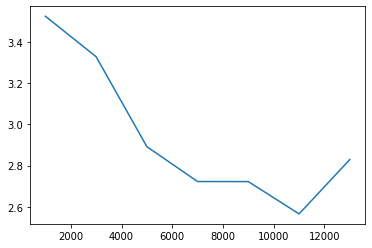

In [36]:
plt.plot(tr_no, rmses)

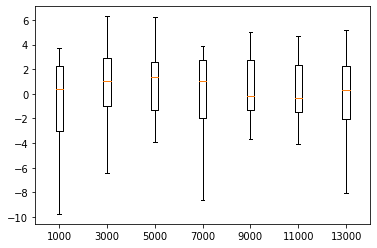

In [45]:
tr_no = list(tr_no)
for i in tr_no:
    plt.boxplot(df_o['error' + str(i)], positions = [tr_no.index(i)],
               labels=[str(i)],sym='')

In [57]:
#Aim to mix dataset from entirely HypoZeo to entirely Rattle
#and plot an accuracy curve and then do box plots.
cat = 'Rattle'
keys = utils.keys_grabber(cat)
soap = utils.descriptor(cut, smo_cut)
full_spec_r, iso_r = utils.puller(keys, soap, cat)

cat = 'HypoZeo'
keys = utils.keys_grabber(cat)
soap = utils.descriptor(cut, smo_cut)
full_spec_h, iso_h = utils.puller(keys, soap, cat)

sample_size = range(0,7001,1000)
rmses = []
for i in sample_size:
    print(i)
    counter = 0
    temp = []
    while counter < 10:
    
        tr_id_r = random.sample(range(len(full_spec_r)),i)
        tr_id_h = random.sample(range(len(full_spec_h)),7000-i)

        tr_sp_r = full_spec_r[tr_id_r]
        tr_sp_h = full_spec_h[tr_id_h]
        tr_ta_r = iso_r[tr_id_r]
        tr_ta_h = iso_h[tr_id_h]
        full_spec = np.concatenate((tr_sp_h, tr_sp_r))
        iso = np.concatenate((tr_ta_h,tr_ta_r))

        sp_sp, tr_sp, tr_ta, te_sp, te_ta = utils.splitter(7000, 1000, full_spec, iso)

        KNM = utils.kerneller(tr_sp, sp_sp, ker_exp)
        KMM = utils.kerneller(sp_sp, sp_sp, ker_exp)
        res = lstsq(KNM.T @ KNM + reg * KMM, KNM.T @ tr_ta, rcond=None)
        c = res[0]    

        tar, pred, rmse = predictor('Polymorphs', cut, smo_cut, ker_exp, reg, c, sp_sp)
        temp.append(rmse)
        o_tar, si_tar, o_pred, si_pred = species_splitter(tar, pred)
        counter += 1
        
        
    rmses.append(sum(temp)/len(temp))
    #n.b this currently runs on last set not all
    df_temp = pd.DataFrame()
    df_temp['a'] = o_pred
    df_temp['b'] = o_tar
    df_o['error' + str(i)] = df_temp['a'] - df_temp['b']
    df_temp = pd.DataFrame()
    df_temp['a'] = si_pred
    df_temp['b'] = si_tar
    df_si['error' + str(i)] = df_temp['a'] - df_temp['b']

0
1000
2000
3000
4000
5000
6000
7000


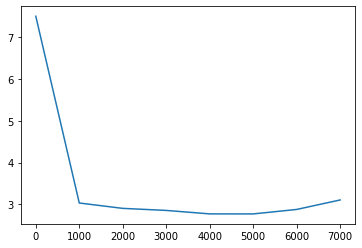

In [68]:
plt.plot(sample_size, rmses)
#n.b right is 100% Rattle and left is 100% HypoZeo
#need to do a species split
#plt.ylim(2,4)

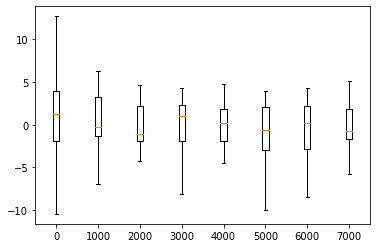

In [67]:
sample_size = list(sample_size)
for i in sample_size:
    plt.boxplot(df_o['error' + str(i)], positions = [sample_size.index(i)],
               labels=[str(i)],sym='')